In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.2 MB/s eta 0:00:00


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.2 MB/s eta 0:00:00


In [3]:
import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import torch
torch.cuda.empty_cache()
import pandas as pd
import torch.nn.functional as F
import numpy as np



from collections import defaultdict
from torch import  nn 
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaModel,AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load dataset

In [4]:
df= datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Data preprocessing

In [5]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [6]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [7]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [8]:

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'Ġwas', 'ĠI', 'Ġlast', 'Ġoutside', '?', 'ĠI', 'Ġam', 'Ġstuck', 'Ġat', 'Ġhome', 'Ġfor', 'Ġ2', 'Ġweeks', '.']
Token IDs: [1779, 21, 38, 94, 751, 116, 38, 524, 4889, 23, 184, 13, 132, 688, 4]


### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [9]:
token_lens = []

for txt in df['train']['text'][:1000]:
  tokens = tokenizer.encode(txt, max_length=1024)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and plot the distribution:

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


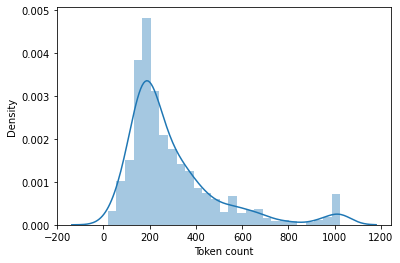

In [10]:
sns.distplot(token_lens)
plt.xlabel('Token count');
plt.show()

Most of the reviews seem to contain less than 400 tokens, but we'll be on the 

---

safe side and choose a maximum length of 512.

In [11]:
MAX_LEN = 512

### Building a sentiment classifier

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [12]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [13]:
df_train = pd.DataFrame(df['train'] )
df_test=pd.DataFrame(df['test'] )
df=pd.concat([df_train,df_test],axis=0)

In [14]:

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [15]:
df_train.shape, df_val.shape, df_test.shape

((45000, 2), (2500, 2), (2500, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [17]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's have a look at an example batch from our training data loader:

In [18]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [19]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


### Sentiment classification with Bert

In [20]:
robert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
last_hidden_state, pooled_output = robert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [23]:
!wget https://www.kaggleusercontent.com/kf/122039412/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..P92S6OWaPhm65AZ8Urq0ng.i0Dm1rOafJeZtcJRc-LusN7PqT2VXhxz5dBa-V_dQAblqaoxc6S8sM5IWZvziRfqeRK9DMUbvKTvO35CDjsU4NzrMuuy3qhjj2B9PaijcgzdNPPfKi-hOxI52vvpgdOQFeD6cIua6MaYwjkd_k-WbNbhezKqhE8suesFTW_jQ05zPnx20JLF5ElmvYYByfyfh16cBE44yEwafGZqpdlAfUyb8pem5D-vv8zYbyFLPK-juSSWPZHha8J5ekvyyjEo2rYlAqzFby4oU7AgGW1v53vn8l_hXK15iBPPqPf4jJDvwwr2AYVJg1p0c2_rN8pp3YMAJSzgklyKhOn6uHooiuou3C7tdlN-bTdC6F9QdfqpbYcDGl1tZUzw3bv7z4eh4XTlaRBbEAspWU2gr9AA5mGUOtF3KeJ_ZL4FwTdXvAlXg8nzzGysJUipstBX0efTATaj6FImKQeLSS2rf1ddwXoJt3sYmiWfy3Ob2iezvLNAu-_M5PuqVcWzmFHMjeV4RLS6rZ7MOWRKyULoc25EbwyiUOJBnXqoXvwCdikncMK6c58oOlcyyL1Lq4lxybE4WjzMP0xpEQffyfHoSPLuO3Kxo-WqLQrfE7i9oTas1_F6YDn1NywE6DrfMarT1ME2S6x33xHG78ioK-lO0RHHuw.y5z-YvcIMOJmez72ZczcnQ/best_model_state.bin

--2023-03-14 10:19:45--  https://www.kaggleusercontent.com/kf/122039412/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..P92S6OWaPhm65AZ8Urq0ng.i0Dm1rOafJeZtcJRc-LusN7PqT2VXhxz5dBa-V_dQAblqaoxc6S8sM5IWZvziRfqeRK9DMUbvKTvO35CDjsU4NzrMuuy3qhjj2B9PaijcgzdNPPfKi-hOxI52vvpgdOQFeD6cIua6MaYwjkd_k-WbNbhezKqhE8suesFTW_jQ05zPnx20JLF5ElmvYYByfyfh16cBE44yEwafGZqpdlAfUyb8pem5D-vv8zYbyFLPK-juSSWPZHha8J5ekvyyjEo2rYlAqzFby4oU7AgGW1v53vn8l_hXK15iBPPqPf4jJDvwwr2AYVJg1p0c2_rN8pp3YMAJSzgklyKhOn6uHooiuou3C7tdlN-bTdC6F9QdfqpbYcDGl1tZUzw3bv7z4eh4XTlaRBbEAspWU2gr9AA5mGUOtF3KeJ_ZL4FwTdXvAlXg8nzzGysJUipstBX0efTATaj6FImKQeLSS2rf1ddwXoJt3sYmiWfy3Ob2iezvLNAu-_M5PuqVcWzmFHMjeV4RLS6rZ7MOWRKyULoc25EbwyiUOJBnXqoXvwCdikncMK6c58oOlcyyL1Lq4lxybE4WjzMP0xpEQffyfHoSPLuO3Kxo-WqLQrfE7i9oTas1_F6YDn1NywE6DrfMarT1ME2S6x33xHG78ioK-lO0RHHuw.y5z-YvcIMOJmez72ZczcnQ/best_model_state.bin
Resolving www.kaggleusercontent.com (www.kaggleusercontent.com)... 35.190.26.106
Connecting to www.kaggleusercontent.com (www.kaggleusercontent.com)|

In [24]:
model = SentimentClassifier(2)
model.load_state_dict(torch.load('best_model_state.bin'))### to load  save model
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 512])
torch.Size([16, 512])


We can show the softmax that we will use for our ODD detection

In [ ]:
# F.softmax(model(input_ids, attention_mask), dim=1)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [26]:

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

:

### Evaluation of model

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'best_model_state.bin')
    best_accuracy = val_acc

In [29]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9480000000000001

#### ODD WITH MAX SOFTMAX

In [30]:
clean_adversarial_sample=pd.read_csv('0')[['text','result_type']]

In [31]:
clean_adversarial_sample

,text,result_type
0,If you want to see a film starring Stan laurel...,1
1,"It pays to watch Reader's Digest. Or Time, if ...",1
2,Thereafter again Woody Allen seems to be compl...,1
3,Disseminate pro-American war effort film that ...,1
4,One of the most interesting things is that thi...,1
...,...,...
4183,I enjoyed this film immensely. I'm really into...,0
4184,This movie had potential to be a good little h...,0
4185,"If you love Chan-wook Park, you know what to e...",0
4186,The DVD release of this movie hopes you will b...,0


In [32]:
def create_attack_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    tokenizer=tokenizer,
    targets=df.result_type.to_numpy(),
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
  )
attack_data_loader = create_attack_data_loader(clean_adversarial_sample, tokenizer, MAX_LEN, BATCH_SIZE)

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

In [33]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs,attack_label_real = get_predictions(
  model,
  attack_data_loader
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Get the maximun for odd

In [35]:
 prob=np.amax(y_pred_probs.numpy(), axis=1)
 prob

array([0.9812572 , 0.9975725 , 0.9933282 , ..., 0.9987739 , 0.99929917,
       0.9991629 ], dtype=float32)

In [36]:
attack_label_real

tensor([1, 1, 1,  ..., 0, 0, 0])

In [37]:
from sklearn import metrics
fpr, tpr,thresholds = metrics.roc_curve(attack_label_real,prob, pos_label=0)
print('AUROC:',metrics.auc(fpr, tpr))

AUROC: 0.7977625617012815


In [38]:
from sklearn.metrics import average_precision_score

print('AUPR:',average_precision_score(attack_label_real,prob,pos_label=0))

AUPR: 0.8004872674834149
